# Executive Summary

This project applies text analytics on a Kaggle dataset of airline tweets to extract insights about customer sentiment, feedback patterns, and key problem areas. Using preprocessing, exploratory analysis, sentiment detection, classification, and summarization, the study demonstrates how NLP can turn raw social media data into actionable insights.

The results show that **negative sentiment dominates (63%), with United and US Airways** receiving the most criticism. The main complaints center around customer service issues, flight delays/cancellations, and baggage handling. Rule-based sentiment tools (VADER, TextBlob) achieved only moderate accuracy (~45–49%), while a Logistic Regression model with TF–IDF features performed significantly better at 78% accuracy, especially in detecting negative tweets. These findings highlight both the challenges and potential of applying machine learning to real-world feedback for improving airline operations and customer satisfaction.

# Problem Statement & Objective

Airlines receive thousands of customer feedback posts daily on social media platforms like Twitter. These tweets contain opinions, complaints, praise, and suggestions that can provide valuable insights into customer satisfaction and pain points. However, manually analyzing this large volume of text is not feasible.

## Objective of this project:
To apply text analytics techniques on a real-world social media dataset of airline tweets. Specifically, we will:

*   Preprocess and clean the text data.
*   Analyze sentiment (positive, neutral, negative) using both rule-based and ML-based methods.
*   Perform feedback analysis and market research, identifying common issues per airline.
*   Classify tweets automatically into sentiment categories.
*   Generate content summarizations and highlight key insights.


**Dataset**:
We use the Twitter US Airline Sentiment dataset (Kaggle), which contains ~14.6K labeled tweets about six major US airlines. Each tweet includes:

*   Text of the tweet
*   Annotated sentiment (positive, neutral, negative)
*   Airline name
*   (Optional) negative reason (e.g., “late flight”, “bad customer service”)

Dataset link: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

By the end of this project, we will generate actionable insights for airlines to improve service quality, as well as demonstrate common text analytics techniques.


### Importing Required Libraries

In [26]:
import re, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from contractions import fix as contractions_fix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading the Dataset

In [28]:
df_tweets = pd.read_csv('/content/Tweets.csv')
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Data Cleaning and Pre-Processing

In [29]:
# Keep the key columns we need
keep_cols = [c for c in ['tweet_id','airline','airline_sentiment','negativereason','text','tweet_created','retweet_count','tweet_location','user_timezone','name'] if c in df_tweets.columns]
df_tweets = df_tweets[keep_cols].copy()

In [30]:
# Drop exact duplicate texts (and keep first)
initial_rows = df_tweets.shape[0]
df_tweets = df_tweets.drop_duplicates(subset=['text']).reset_index(drop=True)
after_dup_rows = df_tweets.shape[0]

In [31]:
# Ensure text non-null / string
df_tweets['text'] = df_tweets['text'].astype(str).str.strip()
df_tweets = df_tweets[df_tweets['text'] != ""].reset_index(drop=True)
after_empty_rows = df_tweets.shape[0]
print(f"initial rows: {initial_rows}, after dropping duplicate texts: {after_dup_rows}, after dropping empty text rows: {after_empty_rows}")

initial rows: 14640, after dropping duplicate texts: 14427, after dropping empty text rows: 14427


In [32]:
# Preprocessing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [33]:
url_pattern = re.compile(r'http\S+|www\.\S+')
mention_pattern = re.compile(r'@\w+')
rt_pattern = re.compile(r'(^RT\s+)|(\bRT\b)')

In [34]:
def clean_text(raw):
    s = str(raw)
    s = s.strip()
    s = re.sub(url_pattern, '', s)
    s = re.sub(mention_pattern, '', s)
    s = re.sub(rt_pattern, '', s)
    s = contractions_fix(s)
    s = s.replace('#', '')
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r'\d+', '', s)
    tokens = [lemmatizer.lemmatize(t) for t in word_tokenize(s) if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

In [35]:
# Apply (this can take a short while on full dataset)
nltk.download('punkt_tab')
df_tweets['clean_text'] = df_tweets['text'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [36]:
# Check how many became empty after cleaning
empty_after_clean = df_tweets['clean_text'].replace('', np.nan).isnull().sum()
print(f"Rows with empty clean_text after cleaning: {empty_after_clean}")

Rows with empty clean_text after cleaning: 25


In [37]:
df_tweets.head()

,tweet_id,airline,airline_sentiment,negativereason,text,tweet_created,retweet_count,tweet_location,user_timezone,name,clean_text
0,570306133677760513,Virgin America,neutral,NaN,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,0,NaN,Eastern Time (US & Canada),cairdin,said
1,570301130888122368,Virgin America,positive,NaN,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,0,NaN,Pacific Time (US & Canada),jnardino,plus added commercial experience tacky
2,570301083672813571,Virgin America,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,0,Lets Play,Central Time (US & Canada),yvonnalynn,today must mean need take another trip
3,570301031407624196,Virgin America,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,0,NaN,Pacific Time (US & Canada),jnardino,really aggressive blast obnoxious entertainmen...
4,570300817074462722,Virgin America,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,0,NaN,Pacific Time (US & Canada),jnardino,really big bad thing


In [38]:
cat_summary = df_tweets.describe(include='object').T
display(cat_summary)

,count,unique,top,freq
airline,14427,6,United,3805
airline_sentiment,14427,3,negative,9080
negativereason,9080,10,Customer Service Issue,2883
text,14427,14427,@AmericanAir we have 8 ppl so we need 2 know h...,1
tweet_created,14427,14190,2015-02-23 10:58:58 -0800,3
tweet_location,9760,3078,"Boston, MA",156
user_timezone,9677,85,Eastern Time (US & Canada),3706
name,14427,7695,JetBlueNews,63
clean_text,14427,14045,thank,51


### Insights: Data Cleaning & Preprocessing

- Selected only relevant columns (tweet text, sentiment, airline, etc.).

- Removed duplicate and empty tweets.

- Cleaned text by removing URLs, mentions, hashtags, retweets, punctuation, digits; expanded contractions; applied stopword removal and lemmatization.

- Created a new clean_text column for analysis.

- After cleaning, only 25 tweets became empty and were dropped.

The dataset is now ready for sentiment analysis and further exploration.

# Exploratory Data Analysis

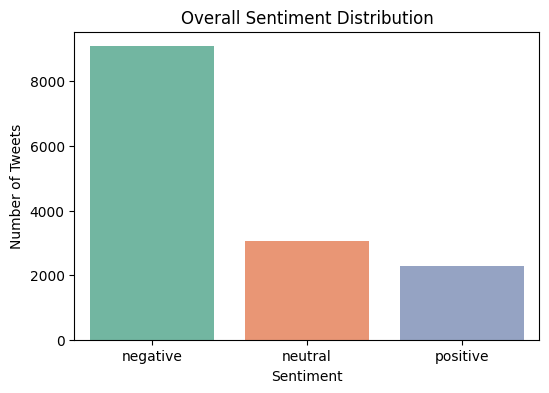

In [39]:
# Overall sentiment distribution
sent_counts = df_tweets['airline_sentiment'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=sent_counts.index, y=sent_counts.values,hue = sent_counts.index, palette = 'Set2')
plt.title("Overall Sentiment Distribution")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment")
plt.show()

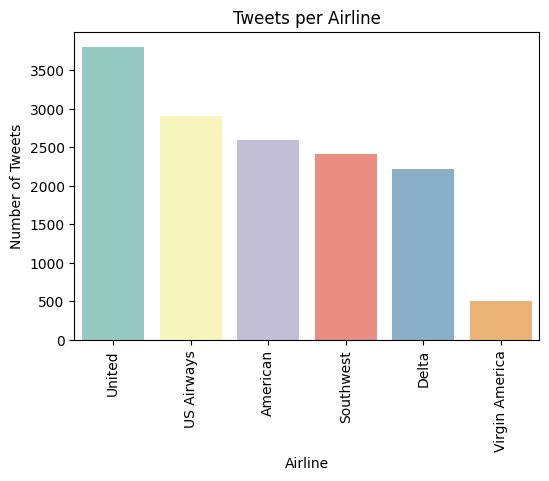

In [40]:
# Airline distribution
air_counts = df_tweets['airline'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=air_counts.index, y=air_counts.values,hue=air_counts.index, palette="Set3")
plt.title("Tweets per Airline")
plt.ylabel("Number of Tweets")
plt.xlabel("Airline")
plt.xticks(rotation=90)
plt.show()

<Figure size 1000x600 with 0 Axes>

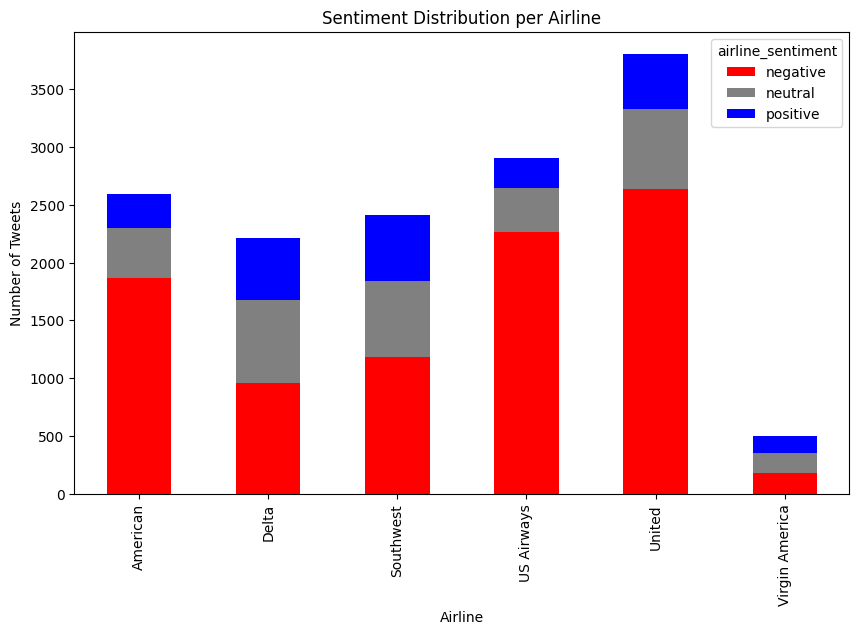

In [41]:
plt.figure(figsize=(10,6))
airline_sent = df_tweets.groupby(['airline','airline_sentiment']).size().unstack(fill_value=0)
colors = {
    "negative": "red",
    "neutral": "grey",
    "positive": "blue"
}
airline_sent.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    color=[colors[sent] for sent in airline_sent.columns]
)
plt.title("Sentiment Distribution per Airline")
plt.ylabel("Number of Tweets")
plt.xlabel("Airline")
plt.xticks(rotation=90)
plt.show()

### Insights: Exploratory Data Analysis (EDA)

- Sentiment distribution: Majority of tweets are negative (9,080), with fewer neutral (3,057) and positive (2,290). The dataset is clearly skewed toward negative sentiment

- Airlines: United (3,805) and US Airways (2,906) have the most tweets, while Virgin America has the least (503)

- Sentiment by airline: United and US Airways receive the most negative tweets, while Virgin America shows a more balanced mix of sentiments

- Overall, the dataset reflects a strong tendency for customers to share complaints on Twitter, especially toward larger airlines

# Sentiment Analysis

In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize analyzers
analyzer = SentimentIntensityAnalyzer()

# --- VADER ---
def vader_label(text):
    vs = analyzer.polarity_scores(text)
    compound = vs['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_tweets['vader_sentiment'] = df_tweets['text'].apply(vader_label)

# --- TextBlob ---
def textblob_label(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return 'positive'
    elif polarity < -0.05:
        return 'negative'
    else:
        return 'neutral'

df_tweets['textblob_sentiment'] = df_tweets['text'].apply(textblob_label)

In [43]:
# --- Compare with annotated labels ---
print("=== VADER vs Annotated ===")
print(classification_report(df_tweets['airline_sentiment'], df_tweets['vader_sentiment']))

print("=== TextBlob vs Annotated ===")
print(classification_report(df_tweets['airline_sentiment'], df_tweets['textblob_sentiment']))

=== VADER vs Annotated ===
              precision    recall  f1-score   support

    negative       0.90      0.44      0.59      9080
     neutral       0.39      0.32      0.35      3057
    positive       0.28      0.91      0.43      2290

    accuracy                           0.49     14427
   macro avg       0.52      0.56      0.45     14427
weighted avg       0.69      0.49      0.51     14427

=== TextBlob vs Annotated ===
              precision    recall  f1-score   support

    negative       0.89      0.32      0.47      9080
     neutral       0.30      0.60      0.40      3057
    positive       0.34      0.76      0.47      2290

    accuracy                           0.45     14427
   macro avg       0.51      0.56      0.45     14427
weighted avg       0.68      0.45      0.46     14427



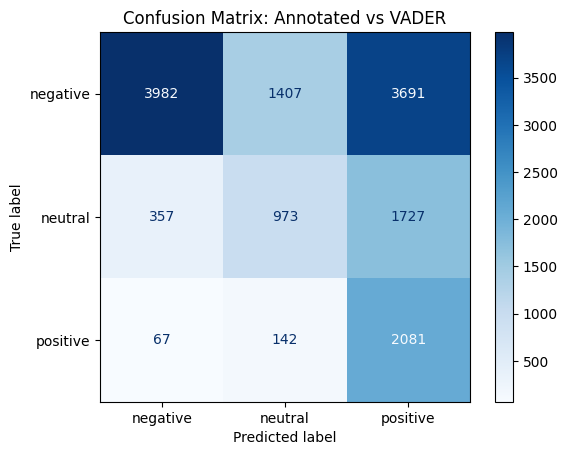

In [44]:
# Confusion matrix for VADER
cm = confusion_matrix(df_tweets['airline_sentiment'], df_tweets['vader_sentiment'], labels=['negative','neutral','positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','neutral','positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Annotated vs VADER")
plt.show()

### Insights: Sentiment Analysis

**VADER results**:

- Good precision for negative tweets but recall is low (many negatives misclassified).

- High recall for positive tweets (91%) but low precision (many false positives).

- Overall accuracy: ~49%.

**TextBlob results**:

- Stronger at identifying neutral tweets (60% recall).

- Positive tweets also captured fairly well (76% recall).

- Overall accuracy: ~45%, slightly lower than VADER.

**Confusion matrix insights**:

- Most tweets are predicted as negative or positive, with many overlaps.

- Neutral tweets are the hardest to classify consistently.

Both methods capture broad sentiment patterns but struggle with nuance. VADER leans toward positive recall, while TextBlob performs better with neutral detection.

# Feedback Analysis & Market Research

In [45]:
from collections import Counter
from wordcloud import WordCloud

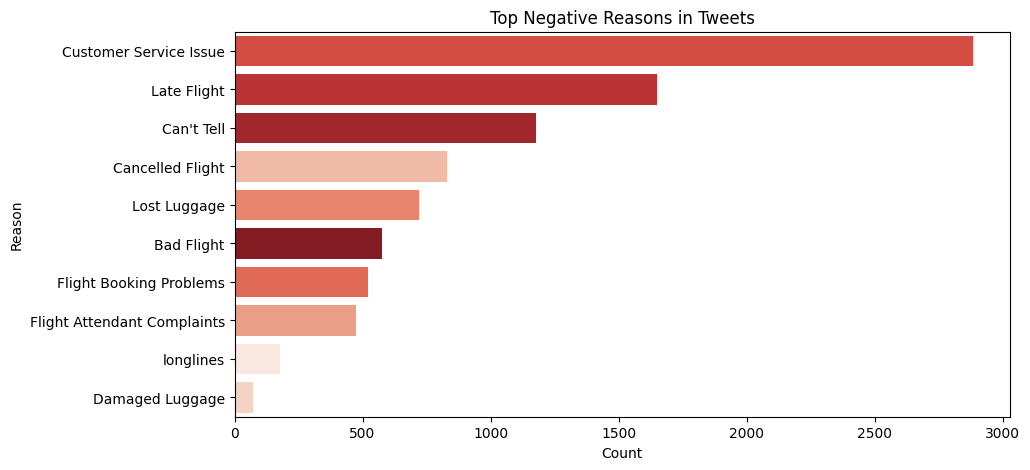

In [46]:
## Distribution of negative reasons
neg_reasons = df_tweets['negativereason'].dropna()
plt.figure(figsize=(10,5))
sns.countplot(y=neg_reasons, order=neg_reasons.value_counts().index,hue= neg_reasons, palette="Reds_r")
plt.title("Top Negative Reasons in Tweets")
plt.xlabel("Count")
plt.ylabel("Reason")
plt.show()

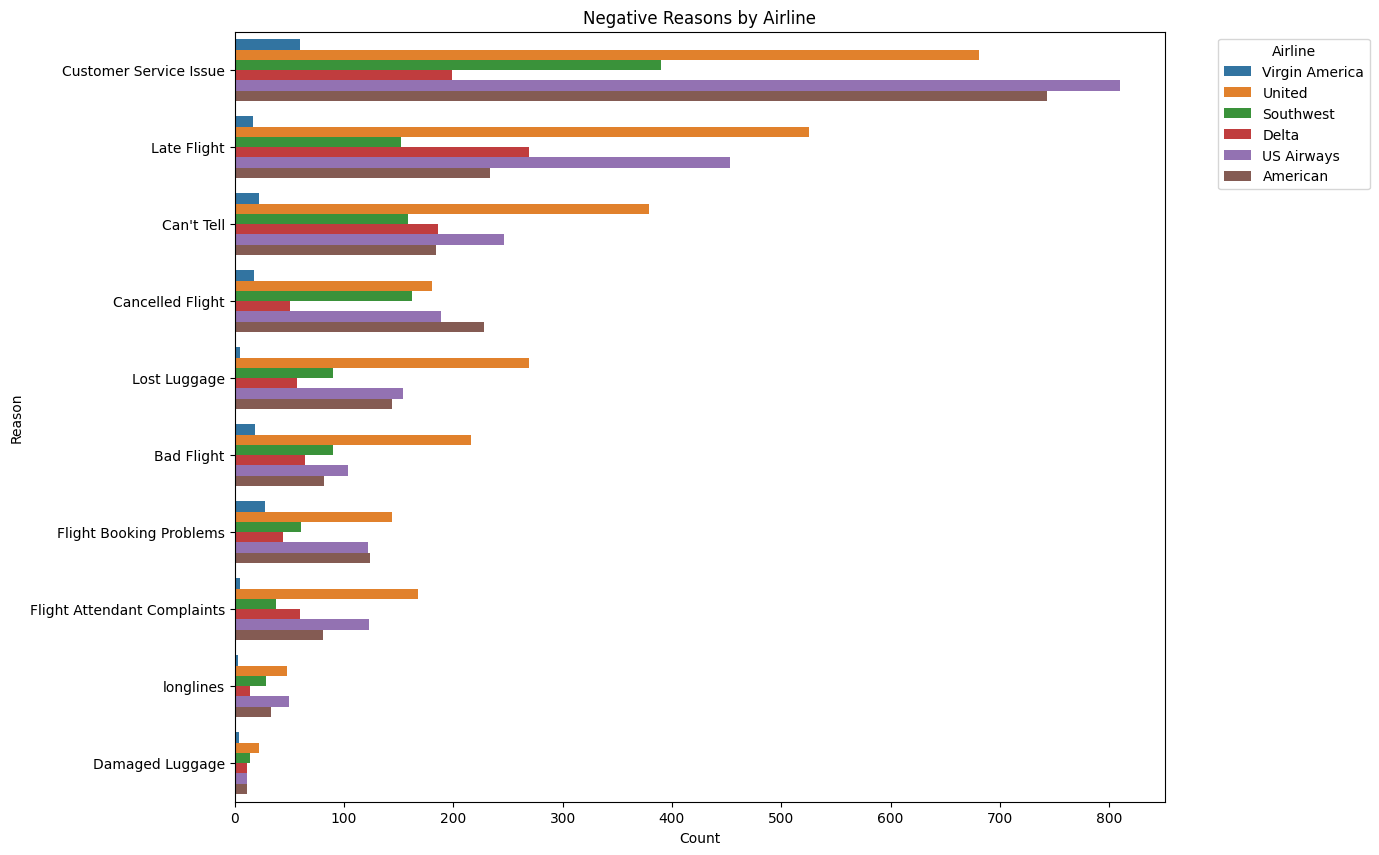

In [47]:
## Negative reasons by Airline
plt.figure(figsize=(12,10))
sns.countplot(data=df_tweets[df_tweets['airline_sentiment']=="negative"],
              y='negativereason', hue='airline',
              order=df_tweets['negativereason'].value_counts().index,
              palette="tab10")
plt.title("Negative Reasons by Airline")
plt.xlabel("Count")
plt.ylabel("Reason")
plt.legend(title="Airline", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

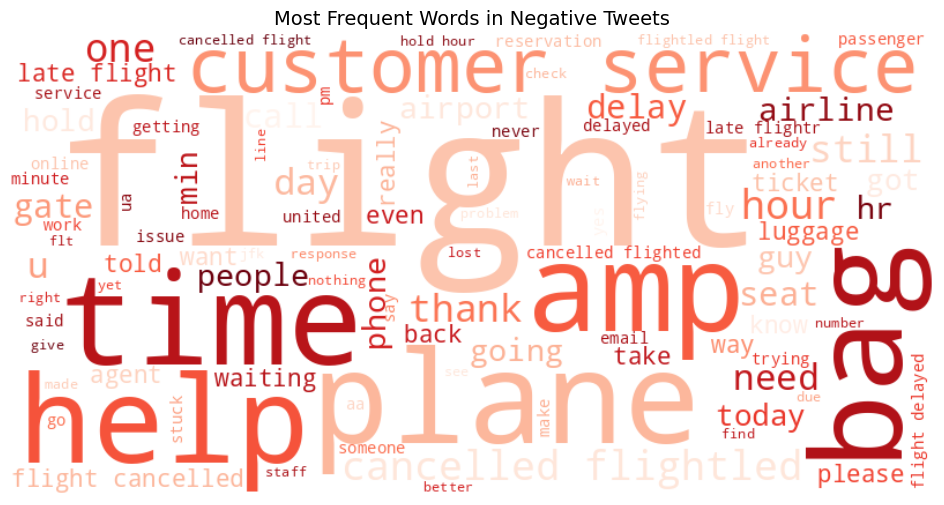

In [48]:
neg_tweets = df_tweets.loc[df_tweets['airline_sentiment']=="negative", 'clean_text']

all_words = " ".join(neg_tweets)
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='Reds', max_words=100).generate(all_words)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Tweets", fontsize=14)
plt.show()

### Insights: Feedback Analysis & Market Research

**Top complaint categories**:

- Most frequent issues: Customer Service (2,883), Late Flights (1,650), and Cancelled Flights (829).

- Smaller but notable issues: Lost Luggage (719) and Bad Flight experience (575).

**Airline comparison**:

- United and US Airways lead in most complaint categories (e.g., customer service, late flights, lost luggage).

- American also has many customer service complaints (743).

- Virgin America shows relatively fewer complaints across all categories.

**Keyword analysis (negative tweets)**:

- Most frequent terms: flight, hour, cancelled, customer, service, bag, help, hold.

- Indicates delays, cancellations, poor service, and baggage issues are core pain points.

Overall, service quality and delays dominate customer dissatisfaction, with United and US Airways being the most criticized, while Virgin America appears comparatively less affected.

# Classification using ML Models

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
X = df_tweets['clean_text']
y = df_tweets['airline_sentiment']

In [51]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [52]:
# Vectorization (TF-IDF) ---
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [53]:
# Train Logistic Regression ---
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [54]:
# Predictions & Evaluation
y_pred = clf.predict(X_test_tfidf)

In [55]:
print("=== Logistic Regression Classification Report ===")
print(classification_report(y_test, y_pred))

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1816
     neutral       0.65      0.47      0.55       612
    positive       0.81      0.60      0.69       458

    accuracy                           0.78      2886
   macro avg       0.75      0.67      0.70      2886
weighted avg       0.77      0.78      0.77      2886



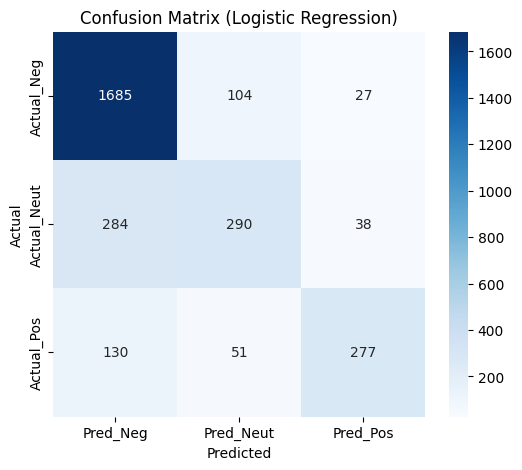

In [56]:
cm = confusion_matrix(y_test, y_pred, labels=['negative','neutral','positive'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Pred_Neg','Pred_Neut','Pred_Pos'],
            yticklabels=['Actual_Neg','Actual_Neut','Actual_Pos'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Insights: Classification — Sentiment Prediction

**Model**: **Logistic Regression** with TF–IDF features.

- Overall accuracy: 78%, which is a strong improvement compared to rule-based methods (VADER/TextBlob at ~45–49%).

**Class performance**:

- Negative tweets: Best performance with 93% recall and 86% F1-score, showing the model is very good at detecting complaints.

- Neutral tweets: Weakest performance (47% recall) — many neutral tweets are misclassified as negative.

- Positive tweets: Reasonable balance (81% precision, 60% recall).

**Confusion matrix**:

- Most misclassifications happen between neutral and negative.

- Positive tweets are sometimes confused with neutral or negative but still identified fairly well.

ML classification can reliably detect sentiment in tweets, especially negative feedback, but further tuning or advanced models may be needed to handle neutral tweets more effectively.

# Content Summarization

In [59]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [60]:
# Extractive Summarization (LexRank)
sample_text = " ".join(df_tweets['clean_text'].sample(200, random_state=42))

parser = PlaintextParser.from_string(sample_text, Tokenizer("english"))
summarizer = LexRankSummarizer()

print("=== Extractive Summary of Sample Tweets ===\n")
for sentence in summarizer(parser.document, 3):  # summarize into 3 sentences
    print("-", sentence)

=== Extractive Summary of Sample Tweets ===

- technically could drive jfk put request tomorrow flight check carry watched handler throw bag miss conveyer belt sat min guy clever year every time u air something happens sat waiting rescheduled flight hour say nd time row charged plane ticket united check cc everytime dmed confirmation number credit replying look forward hopefully one flight home tonight corporate number trying accommodate baggage lost flight cancelled flightled get accommodation even another airline least one free hotel flight going compensate sitting tarmac min missing phx bos connection headphone jack working flight hold hour number speak someone unacceptable need change flight reservation changed longer make connecting flight change without incurring fee although totally answer looking appreciate prompt response bougth mc caren jfk agency delta airway delta refund money usairways accept refund flight ua sitting tarmac min report whyany input make sense suck though st

In [61]:
# Topic Modeling (LDA, same as before)
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

neg_texts = df_tweets.loc[df_tweets['airline_sentiment']=="negative", 'clean_text']

cv = CountVectorizer(max_df=0.8, min_df=5, stop_words='english')
dtm = cv.fit_transform(neg_texts)

lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_model.fit(dtm)

words = cv.get_feature_names_out()
for i, topic in enumerate(lda_model.components_):
    print(f"\n=== Topic {i+1} ===")
    print([words[j] for j in topic.argsort()[-10:]])


=== Topic 1 ===
['people', 'agent', 'ticket', 'hold', 'help', 'seat', 'amp', 'phone', 'service', 'customer']

=== Topic 2 ===
['flying', 'flightled', 'plane', 'delay', 'time', 'today', 'like', 'airline', 'cancelled', 'flight']

=== Topic 3 ===
['help', 'late', 'plane', 'hold', 'delayed', 'cancelled', 'time', 'bag', 'hour', 'flight']


### Insights: Content Summarization

**Extractive summary (LexRank)**:
The system generated a short extract from real tweets highlighting frequent complaints. The summary includes mentions of **cancellations, delays, poor customer service, baggage issues, and frustration with phone support**.

**Topic modeling (LDA)**:

Three key themes were extracted from negative tweets:

- Customer Service Issues → words like customer, service, phone, agent, help.

- Flight Problems → words like flight, cancelled, delay, plane, time.

- Operational Issues → words like bag, hour, late, hold, delayed.

Summarization confirms the main drivers of dissatisfaction: customer service breakdowns, delays/cancellations, and baggage-related problems.

# Final Conclusion & Recommendations

### **Conclusion**

In this project, we applied text analytics on airline tweets to explore customer feedback and sentiment. The workflow included:

- **Data preprocessing & cleaning**: removal of noise (URLs, mentions, stopwords), text normalization, and lemmatization.

- **Exploratory Data Analysis (EDA)**: sentiment and airline-level distributions revealed that negative sentiment dominates (~63%), with United and US Airways facing the highest criticism.

- **Sentiment Analysis (VADER & TextBlob)**: → rule-based methods showed moderate accuracy (~45–49%), struggling mainly with neutral tweets.

- **Feedback Analysis & Market Research**: highlighted key complaint areas: customer service issues, flight delays/cancellations, baggage handling.

- **Classification (ML approach)**: Logistic Regression with TF–IDF achieved 78% accuracy, far outperforming rule-based sentiment methods, especially in detecting negative tweets.

- **Content Summarization**: extractive summarization and topic modeling distilled thousands of tweets into three major themes: service quality, flight operations, and baggage issues.

### **Recommendations**

Based on the findings, the following actions are suggested for airlines:

- Improve Customer Service

- Reduce wait times on calls and social media responses.

- Enhance staff training for better conflict resolution.

- Address Operational Reliability

- Invest in reducing flight delays and cancellations, as they represent the largest complaint share.

- Provide proactive updates to passengers during disruptions.

- Enhance Baggage Handling

- Improve baggage tracking systems to minimize lost/damaged luggage.

- Offer real-time updates and faster resolution for luggage complaints.

- Leverage Social Media Analytics

- Use real-time monitoring of tweets to detect emerging issues early.

- Apply machine learning models (like our classifier) for automated sentiment tagging to prioritize urgent cases.

Future Research/Improvements

- Explore deep learning approaches (e.g., BERT, LSTMs) for improved neutral sentiment detection.

- Extend analysis beyond Twitter to other platforms (Facebook, TripAdvisor, etc.) for a more holistic customer view.